<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:white;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:left;vertical-align:top}
</style>

# 02 Recover individual fruits

Now that we know the location of bounding boxes containg the individual fruits in the raw scan, we proceed to extract those individual fruits.

- This two-step extraction, rather than extracting it as a single process, is meant to give us a chance to re-touch the components before full extraction.

<table class="tg">

<tbody>
  <tr>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/crc_pics/crc_diversity.jpg" alt = "barley" style="width:375px;"/>
        <p style="text-align:center;font-size:20px"><strong>UCR Citrus Colleciton</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src = "https://www.egr.msu.edu/~amezqui3/citrus/crc_pics/citrus_xrayct_scanning.jpeg" alt = "Website icon" style="width:375px;"/>
        <p style="text-align:center;font-size:20px"><strong>X-ray CT scanning</strong></p>
    </td>
    <td class="tg-baqh" style="text-align:left">
        <img src="https://www.egr.msu.edu/~amezqui3/citrus/figs/SR01_CRC3289_12B-19-9_L01_raw.gif" alt="NSF Logo" style="width:220px">
        <p style="text-align:center;font-size:20px"><strong>Raw scans</strong></p>
    </td>
  </tr>
</tbody>
</table>

In [1]:
import os
import sys
import glob

from matplotlib import pyplot as plt

import scipy.ndimage as ndimage
import scipy.spatial as spatial
import numpy as np
import pandas as pd

import tifffile as tf

### Load raw scan and define a destination directory

- `dst` path to store the individual fruit images
- `box_src` path to where the bounding box data was stored

In [2]:
img_file = '../preproc/raw/SR01_CRC3289_12B-19-9_beam.tif'
#img_file =  '../preproc/raw/SW01_CRC3030_12B-8-5_beam.tif'
#img_file = '../preproc/raw/SW02_CRC3746_12B-17-7_beam.tif'
#img_file = '../preproc/raw/SW03_CRC1241-B_12B-4-3_beam.tif'

#img_file = '../preproc/raw/WR09_CRC3469_12B-36-9_beam.tif'
#img_file = '../preproc/raw/WR18_CRC2863_12A-39-9_beam.tif'

comp_dst = '../preproc/comps/'
_ , fname = os.path.split(img_file)
bname = os.path.splitext(fname)[0][:-5]

dst = comp_dst + bname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)

In [4]:
img = tf.imread(img_file)

In [3]:
box_src = '../preproc/masks/'
boxes_file = box_src + bname + '.csv'
dfboxes = pd.read_csv(boxes_file)
dfboxes

,z0,y0,x0,z1,y1,x1,thr
0,12,788,0,860,1524,753,91
1,0,0,452,817,632,1076,91
2,24,775,1002,638,1305,1515,91
3,101,31,23,961,1555,1538,91


### Adjust the coordinate values

- The bounding box coordinates are wrt zero-cleaned image
- We need to take into account zero-valued planes removed from the original raw scan
- Add these planes to get the actual bounding-box coordinates wrt raw image.

In [5]:
def adjust_box_values(dfboxes):
    boxes = dfboxes.values.copy()
    for i in range(len(boxes)-1):
        boxes[i,0] += boxes[-1,0]
        boxes[i,3] += boxes[-1,0]

        boxes[i,1] += boxes[-1,1]
        boxes[i,4] += boxes[-1,1]

        boxes[i,2] += boxes[-1,2]
        boxes[i,5] += boxes[-1,2]

    return boxes

In [6]:
boxes = adjust_box_values(dfboxes)
boxes

array([[ 113,  819,   23,  961, 1555,  776,   91],
       [ 101,   31,  475,  918,  663, 1099,   91],
       [ 125,  806, 1025,  739, 1336, 1538,   91],
       [ 101,   31,   23,  961, 1555, 1538,   91]])

### Check an individual bounding box

(817, 632, 624)


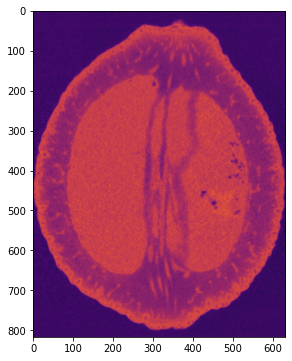

In [52]:
plt.figure(figsize=(6,6))
i = 1
k = 300
comp = img[boxes[i,0]:boxes[i,3], boxes[i,1]:boxes[i,4], boxes[i,2]:boxes[i,5]]
print(comp.shape)
plt.imshow(comp[:,:,k], cmap='inferno', origin='upper', 
           vmin=0, vmax=255);

### Retouch the fruit: fill in interior holes

- The interior of the fruit can be low density
- The initial thresholding may create artificial holes inside the fruit
- Therefore, we need to fill those holes.
- Each individual 2D layer is:
    - Dilated
    - Holes filled
    - Eroded
- This procedure is done for all 2D layers across all three X,Y,Z directions

In [9]:
def determine_mask(citrus, thr, its=4):
    mask = citrus.copy()
    mask[mask < thr] = 0
    mask[mask > 0] = 1
    structure = ndimage.generate_binary_structure(mask.ndim-1,mask.ndim-1)

    for k in range(mask.shape[2]):
        foo = mask[:,:,k]
        foo = ndimage.binary_dilation(foo, structure=structure, iterations=its)
        foo = ndimage.binary_fill_holes(foo)
        foo = ndimage.binary_erosion(foo, structure=structure, iterations=its)
        mask[:,:,k] = foo

    for k in range(mask.shape[0]):
        foo = mask[k, :, :]
        foo = ndimage.binary_dilation(foo, structure=structure, iterations=its)
        foo = ndimage.binary_fill_holes(foo)
        foo = ndimage.binary_erosion(foo, structure=structure, iterations=its)
        mask[k,:,:] = foo

    for k in range(mask.shape[1]):
        foo = mask[:, k, :]
        foo = ndimage.binary_dilation(foo, structure=structure, iterations=its)
        foo = ndimage.binary_fill_holes(foo)
        foo = ndimage.binary_erosion(foo, structure=structure, iterations=its)
        mask[:, k, :] = foo

    return mask

### Polish the fruit: remove extraneous pixels

- The bounding box may contain parts of other fruits
- Thus we only keep the largest connected component

In [10]:
def polish_mask(img):

    box = img.copy()
    labels,num = ndimage.label(img, structure=ndimage.generate_binary_structure(img.ndim, 1))
    print(num,'components to polish')

    if num != 1:
        hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
        sz_hist = np.sum(hist)
        argsort_hist = np.argsort(hist)[::-1]

        i = argsort_hist[0]
        mask = labels == i+1
        box[~mask] = 0

    return box

### Save the individual, polished scan

- An additional visual check can be plotted for sanity purposes
- Individual scans will be labeled `L00`, `L01`, `L02`, etc.
- `L00` corresponds to the largest fruit
- `L01` to the second largest fruit in the raw scan, and so on

In [11]:
def write_individual_comps(img, boxes, thr, dst='./', bname='file', sanity=False, sanity_dst='./'):
    for lab in range(len(boxes)-1):
        citrus = img[boxes[lab,0]:boxes[lab,3], boxes[lab,1]:boxes[lab,4], boxes[lab,2]:boxes[lab,5]].copy()
        mask = determine_mask(citrus, thr)
        mask = polish_mask(mask)

        cleaned = mask*citrus

        filename = dst + bname + '_L{:02d}.tif'.format(lab)
        tf.imwrite(filename, cleaned, photometric='minisblack',compress=3)
        print(bname, '\tlabel', lab,'written')

        if sanity:
            k = int(cleaned.shape[2]*.5)
            vitaminC.plot_comp_cleaning(citrus, mask, cleaned, k, thr, lab, bname=bname, pic_dst=sanity_dst)

In [21]:
def plot_comp_cleaning(citrus, mask, cleaned, k, thr, lab=0, writefig=False, bname='file', pic_dst='./'):
    cmap = 'inferno'
    fig, ax = plt.subplots(2,2,figsize=(12, 10))

    j = (0,0)
    conv = ax[j].imshow(citrus[:,:,k], cmap=cmap, vmin=0)
    ax[j].axis('off')
    ax[j].set_title('Raw', fontsize=20)
    cbar = plt.colorbar(conv, ax=ax[j])
    cbar.ax.tick_params(labelsize=15)

    comp = citrus[:,:,k].copy()
    comp[comp < thr] = 0
    j = (0,1)
    conv = ax[j].imshow(comp, cmap=cmap, vmin=0)
    ax[j].axis('off')
    ax[j].set_title('Template', fontsize=20)
    cbar = plt.colorbar(conv, ax=ax[j])
    cbar.ax.tick_params(labelsize=15)

    j = (1,0)
    conv = ax[j].imshow(mask[:,:,k], cmap=cmap, vmin=0)
    ax[j].axis('off')
    ax[j].set_title('Masked', fontsize=20)
    cbar = plt.colorbar(conv, ax=ax[j])
    cbar.ax.tick_params(labelsize=15)

    j = (1,1)
    conv = ax[j].imshow(cleaned[:,:,k], cmap=cmap, vmin=0)
    ax[j].axis('off')
    ax[j].set_title('Thresholded', fontsize=20)
    cbar = plt.colorbar(conv, ax=ax[j])
    cbar.ax.tick_params(labelsize=15)

    plt.suptitle(bname + ', Comp {}'.format(lab), fontsize=25);

    if writefig:
        filename = pic_dst + bname + '_L{}_{}.jpg'.format(lab,k)
        plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight');
        plt.close()

In [25]:
lab = 3
citrus = img[boxes[lab,0]:boxes[lab,3], boxes[lab,1]:boxes[lab,4], boxes[lab,2]:boxes[lab,5]].copy()
thr = boxes[0,-1]

In [26]:
mask = determine_mask(citrus, thr)

In [27]:
box = mask.copy()
labels,num = ndimage.label(mask, structure=ndimage.generate_binary_structure(mask.ndim, 1))
print(num,'components to polish')

1 components to polish


In [29]:
if num != 1:
    hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
    sz_hist = np.sum(hist)
    argsort_hist = np.argsort(hist)[::-1]

    i = argsort_hist[0]
    mask = labels == i+1
    box[~mask] = 0

In [30]:
cleaned = mask*citrus

In [31]:
filename = dst + bname + '_L{:02d}.tif'.format(lab)
tf.imwrite(filename, cleaned, photometric='minisblack',compress=3)
print(bname, '\tlabel', lab,'written')

WR18_CRC2863_12A-39-9 	label 3 written


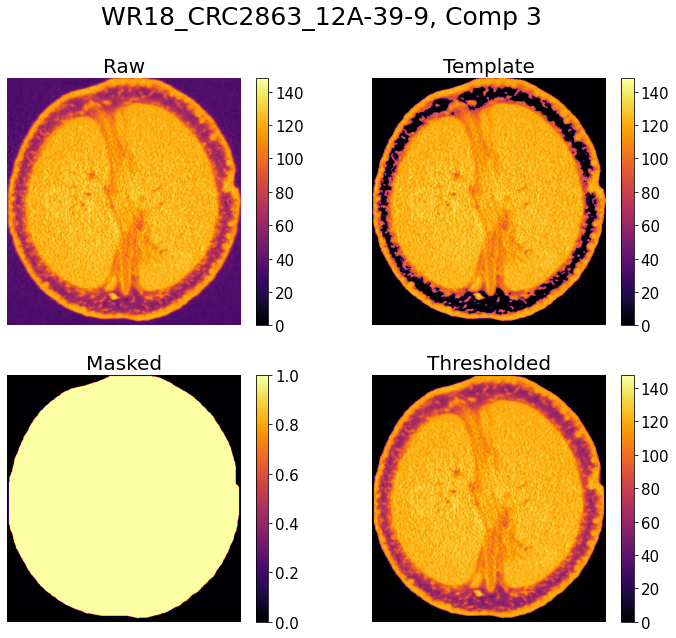

In [32]:
k = int(cleaned.shape[2]*.5)
plot_comp_cleaning(citrus, mask, cleaned, k, thr, lab, bname=bname)

In [34]:
len(boxes)-1

5